# Homework 3
## BUSN 41204 - 2023

- Aman Krishna
- Christian Pavilanis
- Jingwen Li
- Yazmin Ramirez Delgado

# 1 Load relevant libraries

In [104]:
# First we import the necessary libraries
import pandas as pd
pd.set_option("display.precision", 4)
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sn
import scipy as sp
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
import random 
import math
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
# Fit a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 2 Load the data

Here we will load the data from the CSV data file, examine its structure, and fix the data types incorrectly identified by R when importing from CSV.

>STCdata_A<-read.csv('travelData.csv')\
>STCdata_A<-STCdata_A[,-1]

You can use the function str to quickly check the internal structure of an R object. Here we are using it to investigate type of data in each column of the loaded data.

>str(STCdata_A)

Notice that some columns are identified as numerical or integer, but really the should be factors.

For instance, we have that column From.Grade

>n_distinct(STCdata_A$From.Grade, na.rm = FALSE)  ## n_distinct is a function from dplyr package

only has 11 levels. It might be a better idea to treat it as a factor instead. You can fix incorrectly classified data types as follows:

In [71]:
STCdata_A = pd.read_csv('travelData.csv')
STCdata_A = STCdata_A.iloc[:, 1:]

In [72]:
STCdata_A.dtypes

Program.Code                       object
From.Grade                        float64
To.Grade                          float64
Group.State                        object
Is.Non.Annual.                      int64
Days                                int64
Travel.Type                        object
Departure.Date                     object
Return.Date                        object
Deposit.Date                       object
Special.Pay                        object
Tuition                             int64
FRP.Active                          int64
FRP.Cancelled                       int64
FRP.Take.up.percent.              float64
Early.RPL                          object
Latest.RPL                         object
Cancelled.Pax                       int64
Total.Discount.Pax                  int64
Initial.System.Date                object
Poverty.Code                       object
Region                             object
CRM.Segment                       float64
School.Type                       

In [73]:
distinct = STCdata_A['From.Grade'].unique()
len(distinct)

11

In [74]:
STCdata_A['From.Grade'] = STCdata_A['From.Grade'].astype('category')

In [75]:
STCdata_A.dtypes

Program.Code                        object
From.Grade                        category
To.Grade                           float64
Group.State                         object
Is.Non.Annual.                       int64
Days                                 int64
Travel.Type                         object
Departure.Date                      object
Return.Date                         object
Deposit.Date                        object
Special.Pay                         object
Tuition                              int64
FRP.Active                           int64
FRP.Cancelled                        int64
FRP.Take.up.percent.               float64
Early.RPL                           object
Latest.RPL                          object
Cancelled.Pax                        int64
Total.Discount.Pax                   int64
Initial.System.Date                 object
Poverty.Code                        object
Region                              object
CRM.Segment                        float64
School.Type

Fix other columns that are numeric at the moment, but could be converted to factors. The following line first finds numeric columns and then identifies the number of unique elements in each one.

In [76]:
unique_per_column = STCdata_A.select_dtypes(include=['float64','int64']).columns
unique_per_column = [(len (STCdata_A[col].unique()), col) for col in unique_per_column]
unique_per_column = pd.DataFrame(unique_per_column, columns=['unique', 'column'])
unique_per_column

,unique,column
0,11,To.Grade
1,2,Is.Non.Annual.
2,12,Days
3,1230,Tuition
4,93,FRP.Active
5,29,FRP.Cancelled
6,476,FRP.Take.up.percent.
7,34,Cancelled.Pax
8,26,Total.Discount.Pax
9,12,CRM.Segment


Let us convert every column that has less than 15 unique values into a factor. The following line identify names of such columns.

In [77]:
# If the number of unique values is less than 15, we will convert the column to a factor
for col in unique_per_column[unique_per_column['unique'] < 15]['column']:
    STCdata_A[col] = STCdata_A[col].astype('category')

# Print the number of colums that changed
printmd('**Number of columns that changed:** {}'.format(len(unique_per_column[unique_per_column['unique'] < 15]['column'])))

**Number of columns that changed:** 10

Now let’s take care of date columns.

In [78]:
date_columns = ['Departure.Date', 'Return.Date', 'Deposit.Date', 'Early.RPL', 'Latest.RPL','Initial.System.Date', 'FirstMeeting', 'LastMeeting']
STCdata_A[date_columns] = STCdata_A[date_columns].apply(pd.to_datetime, format='%m/%d/%Y')


In [79]:
STCdata_A.dtypes

Program.Code                              object
From.Grade                              category
To.Grade                                category
Group.State                               object
Is.Non.Annual.                          category
Days                                    category
Travel.Type                               object
Departure.Date                    datetime64[ns]
Return.Date                       datetime64[ns]
Deposit.Date                      datetime64[ns]
Special.Pay                               object
Tuition                                    int64
FRP.Active                                 int64
FRP.Cancelled                              int64
FRP.Take.up.percent.                     float64
Early.RPL                         datetime64[ns]
Latest.RPL                        datetime64[ns]
Cancelled.Pax                              int64
Total.Discount.Pax                         int64
Initial.System.Date               datetime64[ns]
Poverty.Code        

In [80]:
# Print the number of colums that changed
printmd('**Number of columns that changed:** {}'.format(len(STCdata_A.select_dtypes(include=['object']).columns)))
STCdata_A[STCdata_A.select_dtypes(include=['object']).columns] = STCdata_A.select_dtypes(include=['object']).apply(lambda x: x.astype('category'))

**Number of columns that changed:** 20

### 3 Data preprocessing

The data contains a number of columns with missing values. Let’s investigate. The following tells us the number of missing values in each column.
> sapply(STCdata_A, function(x) sum(is.na(x)))
> 
Dealing with missing values is a challenging problem, which could occupy a quarter of its own. The purpose of this homework is not to investigate in-depth approaches to dealing with missing values, but rather to investigate classification. For that reason, we take the following simple approach.

The function fixNAs below fixes missing values. The function defines reactions:

• adds a new category “FIXED_NA” for a missing value of a categorical/factor variable;\
• fills zero value for a missing value of a numeric variable;\
• fills “1900-01-01” for a missing value of a date variable.

Then it loops through all columns in the dataframe, reads their types, and loops through all the values, applying the defined reaction to any missing data point. In addition, the function creates a surrogate dummy variable for each column containing at least one missing value (for example, Special.Pay_surrogate), which takes a value of 1 whenever the original variable (Special.Pay) has a missing value, and 0 otherwise.

In [81]:
# Count the number of NAs in Special Pay
printmd('**Number of NAs in Special Pay:** {}'.format(STCdata_A['Income.Level'].isna().sum()))

**Number of NAs in Special Pay:** 62

In [82]:
def fixNAs(data_frame):
  # Define reactions to NAs
  integer_reac = 0
  factor_reac = "FIXED_NA"
  character_reac = "FIXED_NA"
  date_reac = pd.to_datetime("1900-01-01")
  
  for col in data_frame.columns:
    col_data = data_frame[col]
    if col_data.dtype in [int, float]:
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(integer_reac, inplace=True)
    elif col_data.dtype == object:
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(character_reac, inplace=True)
    elif col_data.dtype == 'datetime64[ns]':
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(date_reac, inplace=True)
    elif col_data.dtype == 'category':
      if pd.isnull(col_data).sum() > 0:
        #adds a new category "FIXED_NA" for a missing value of a categorical/factor variable
        data_frame[col].cat.add_categories('FIXED_NA', inplace=True)
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(factor_reac, inplace=True)

  return data_frame

In [83]:
STCdata_A = fixNAs(STCdata_A)

We can see that the columns do not have any missing values any more.

In [84]:
any(STCdata_A.isnull().sum() > 0)

False

Next, we combine the rare categories. Levels that do not occur often during training tend not to have reliable effect estimates and contribute to over-fit.

Let us check for rare categories in the variable Group.State.

In [85]:
STCdata_A['Group.State'].value_counts().to_frame()

,Group.State
CA,718
TX,308
WA,147
IL,104
CO,89
MI,71
FL,62
OH,53
AZ,53
OR,51


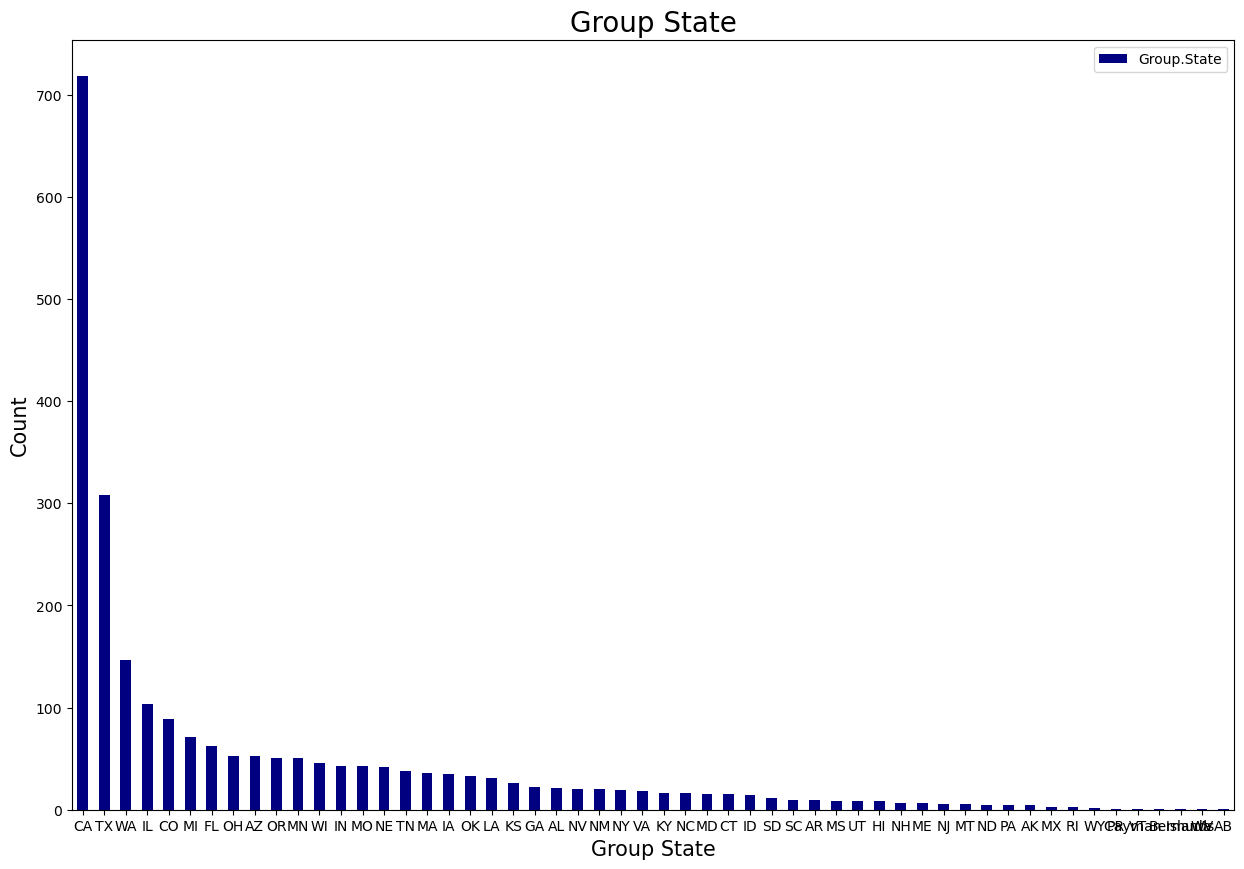

In [86]:
plot = STCdata_A['Group.State'].value_counts().to_frame()
# Plot a beautiful bar chart
plot.plot.bar(figsize=(15,10), fontsize=10, rot=0, color='navy')
plt.title('Group State', fontsize=20)
plt.xlabel('Group State', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

Let us create a custom function to combine rare categories.
The function again loops through all the columns in the dataframe,
reads their types, and creates a table of counts 
for each level of the factor/categorical variables. All
levels with counts less than the `mincount` are combined into "other."
The function combines rare categories into "Other."+the name of the 
original variable (for example, `Other.State`).
This function has two arguments: 

- the name of the dataframe; and 
- the count of observations in a category to define "rare."

Let us combine categories with $<10$ values in `STCdata` into "Other."
Ultimately, it is going to depend on the person doing the analysis on what
they decide to call ``rare''.

In [87]:
def combine_rare_categories(data_frame, mincount):
    for column in data_frame.columns:
        if data_frame[column].dtype == "category":
            replace = data_frame[column].value_counts()[data_frame[column].value_counts() < mincount].index
            data_frame[column].replace(to_replace = replace, value = "Other." + column, inplace = True)
    return data_frame

In [88]:
STCdata_A = combine_rare_categories(STCdata_A, 10)

Let us look at `Group.State` again.

In [89]:
STCdata_A['Group.State'].value_counts().to_frame()

,Group.State
CA,718
TX,308
WA,147
IL,104
CO,89
Other.Group.State,82
MI,71
FL,62
AZ,53
OH,53


In [90]:
# Number of columns
printmd('**Number of columns:** {}'.format(len(STCdata_A.columns)))

**Number of columns:** 73

# 4 Split the data into training and testing sets

This is a very important step, both conceptually and technically. Conceptually, because the goal of predictive modeling is not to build a model that fits well the data it trains on, but rather one that would best predict the new data. A test set is in this sense the best representation of what the “new data” may look like. Technically, to facilitate comparison between different models, we need to maintain the same IDs in the corresponding sets at all times. We will accomplishes this through two “tricks”:

• a random seed ensures that the random-number generator is initialized identically in each run;

• the inTrain vector is created once and can then be applied anytime the data needs to be split.

By default, the code sets 500 data points in the test set, and the remainder 1,889 into the training set.

In [91]:
# set a random number generation seed to ensure that the split is the same every time set.seed(233)
# split the data into training and test sets
import random
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(STCdata_A, test_size=1-1888/2389, random_state=233)

Let us check that both the training and test sets have a similar proportion of positive and negative cases.

In [92]:
print('Training set proportion:')
print(df_train['Retained.in.2012.'].value_counts(normalize=True))

print('Test set proportion:')
print(df_test['Retained.in.2012.'].value_counts(normalize=True))

Training set proportion:
1    0.6049
0    0.3951
Name: Retained.in.2012., dtype: float64
Test set proportion:
1    0.6168
0    0.3832
Name: Retained.in.2012., dtype: float64


# 5 Fitting a logistic regression model

Let us fit a logistic regression model with all the variables included on the training set.

In [94]:
X = df_train.drop('Retained.in.2012.', axis=1)
y = df_train['Retained.in.2012.']

# Drop the columns that have both normal and surrogate variables, drop the normal variables and keep the surrogate variables
X = X.drop(['From.Grade','Early.RPL','Latest.RPL','Initial.System.Date','Total.School.Enrollment','FirstMeeting','LastMeeting',
            'DifferenceTraveltoFirstMeeting','DifferenceTraveltoLastMeeting','FPP.to.School.enrollment','To.Grade','Special.Pay',
            'Poverty.Code','CRM.Segment','MDR.Low.Grade','MDR.High.Grade','Income.Level','SchoolSizeIndicator'], axis=1)

# Change the columns that are type date to integer
for col in X.columns:
    if X[col].dtype == 'datetime64[ns]':
        X[col] = X[col].astype(int)

X = pd.get_dummies(X, drop_first=True)

# Fit a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [95]:
# Get the statistics of the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = logreg.predict(X)
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       746
           1       0.61      1.00      0.75      1142

    accuracy                           0.61      1888
   macro avg       0.80      0.50      0.38      1888
weighted avg       0.76      0.61      0.46      1888

[[   2  744]
 [   0 1142]]


The model is overfit. It has too many insignificant variables.\
Let us fit a much simpler model. We will use stepwise regressions.\
Recall stepwise regression from BUS 41100 Applied regression course. See, for example, Week 9 slides. You can also check Section 6.1.2 of the ISLR book.\
There are three approaches to running stepwise regressions: backward, forward and both. We need to specify criterion for inclusion/exclusion of variables. We will use one based on Bayesian information criteria.\
Observe the process of variables being added to the model, (labeled by “+” in the output), gradual expansion of the model, and improvement of BIC.

While we are investigating variable selection in logistic regression models, let us also use a more modern approach to variable selection. We will use the lasso.

If you have not seen this in BUS 41100 Applied regression course, do not worry. We will provide more details in the Week 5. You can also check Section 6.2.2 of the ISLR book.

I provide the code to fit a lasso logistic regression model. We find coefficients β that minimize the deviance loss plus the penalty.

First, we need to create a model matrix that will be used as an input to the package.

In [96]:
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

#
# Create an instance of Lasso Regression implementation
#
lasso_cv = LassoCV(cv=5, random_state=233)
#
# Fit the Lasso model
#
lasso_cv.fit(X, y)
#
# Create the model score
#
lasso_cv.score(X, y)


0.019070920633219024

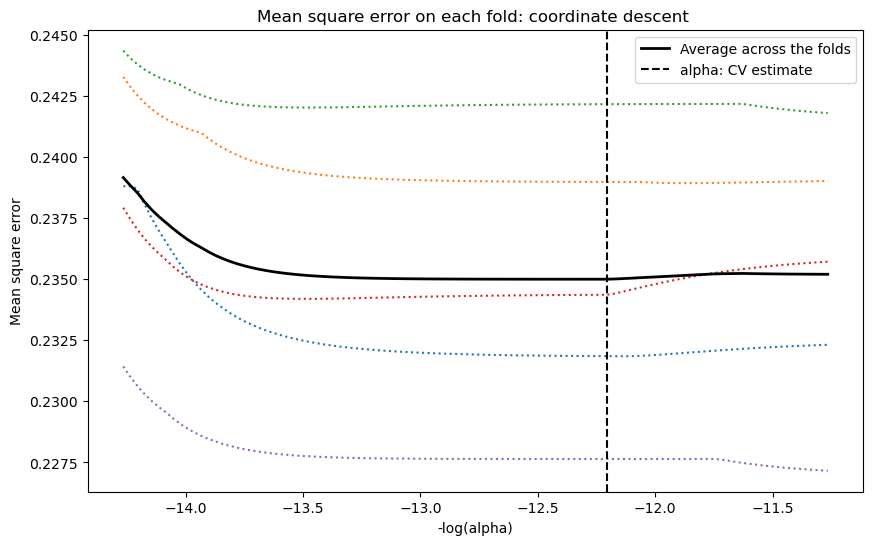

In [124]:
# Plot the cross-validation curve
m_log_alphas = -np.log10(lasso_cv.alphas_)
plt.figure(figsize=(10, 6))
plt.plot(m_log_alphas, lasso_cv.mse_path_, ':')
plt.plot(m_log_alphas, lasso_cv.mse_path_.mean(axis=-1), 'k',
            label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_cv.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()